# 基于MindSpore的YOLOv5实现


1. 算法介绍 
> YOLOv5是一种单阶段目标检测算法，该算法在YOLOv4的基础上添加了一些新的改进思路，使其速度与精度都得到了极大的性能提升。需要说明的是，YOLOv5没有论文，其作者是Mosaic Augmentation 的创造者，YOLOv5在gtihub上的链接为：https://github.com/ultralytics/yolov5


> 1.1 模型结构：
    YOLOv5网络模型主要有四个部分组成，分别为：输入端，Backbone，Neck，Prediction。和YOLOv4相比，YOLOv5做了一些优化，主要有(1) 输入端：Mosaic数据增强，（2）Backbone：Focus结构，CSP结构, (3）Neck：FPN+PAN结构,（4）Prediction：GIOU_Loss。下面是YOLOv5的整体网络结构图：
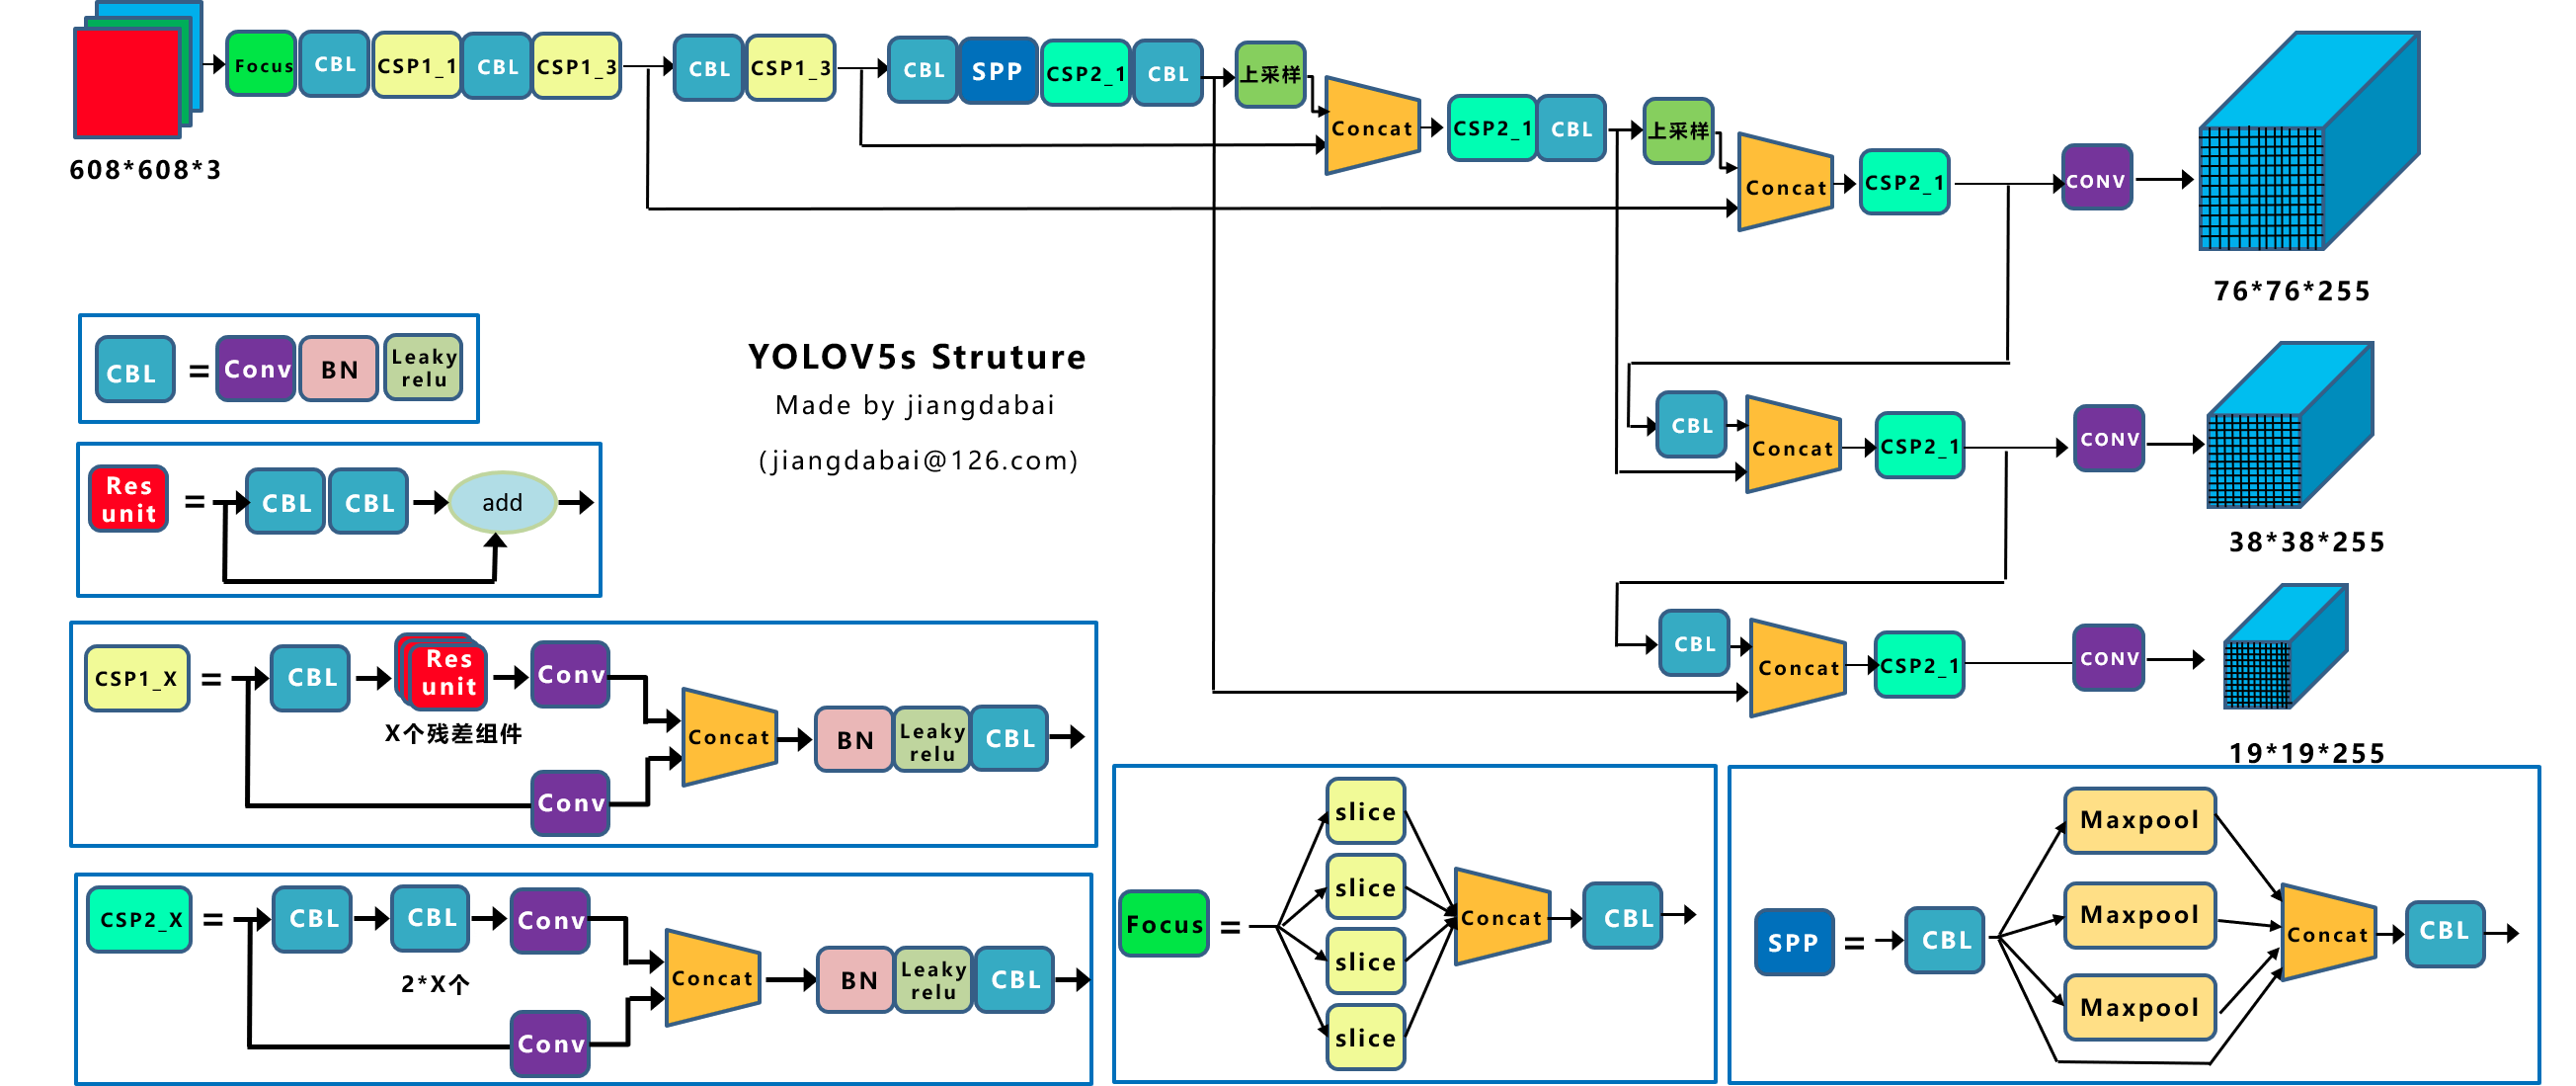

2. 模型实现

> 2.1 环境准备与数据读取

   > 案例基于MindSpore1.8的GPU版本实现，在GXT1080TI单卡上完成训练。
    案例使用数据集为coco_mini，是从COCO数据集中分离出来的一小部分数据,其中训练集50张图像，测试集10张图像，数据格式为图像和json文件。coco_mini数据集的下载链接为: https://pan.baidu.com/s/1FJ_Css0KoXqKqifmUzmBUw 提取码: g55f。下载好的数据集包括3个文件，分别对应数据标签，训练数据，测试数据，文件路径结构如下：
    
      .datasets/
        └── coco_mini_dataset
            ├── annotations
                ├──instances_train2017.json
                └──instances_val2017.json 
            ├── train2017
            └── val2017
     
   > 下面是数据的可视化展示:
    

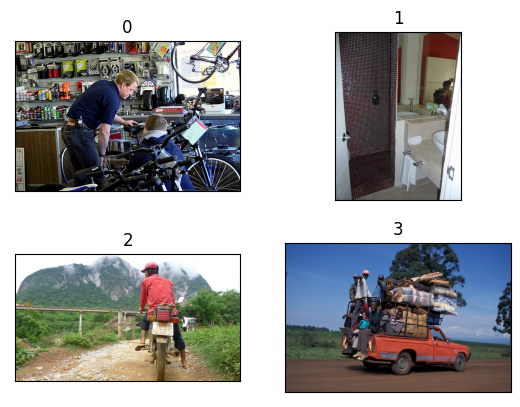

In [1]:
import numpy as np
import matplotlib
import os
import glob
import math
from PIL import Image, ImageSequence
from matplotlib import pyplot as plt

#显示下载好的数据
train_image_path = "dataset/mini_coco_dataset/train2017/"

image = []
for root, dirs, files in os.walk(train_image_path):
    for i in range(6):
        image.append(files[i])

def show_image(image_list,num = 6):
    '''
    #image_list: 图像序列，numpy数组
    #num: 显示图片的数量
    '''
    img_titles = []
    for ind,img in enumerate(image_list):
        if ind == num:
            break
        img_titles.append(ind)

    for i in range(len(img_titles)):
        if len(img_titles) > 6:
            row = 3
        elif 3<len(img_titles)<=6:
            row = 2
        else:
            row = 1
        col = math.ceil(len(img_titles)/row)
        plt.subplot(row,col,i+1),plt.imshow(Image.open(os.path.join(train_image_path, image[i])))
        plt.title(img_titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
show_image(image,num=4)

> 2.2 参数定义（包括lr,epoch, pretrained_checkpoints)

In [12]:
import argparse
import mindspore as ms


import sys
sys.argv=['']
del sys

ms.set_seed(1)

parser = argparse.ArgumentParser('mindspore coco training')

# device related
parser.add_argument('--device_target', type=str, default='GPU', help='device where the code will be implemented.')

# dataset related
parser.add_argument('--data_dir', default='./dataset/mini_coco_dataset/', type=str, help='Train dataset directory.')
parser.add_argument('--output_dir', default='./output', type=str, help='output')
parser.add_argument('--pretrained_checkpoint', default='',type=str, help='pretrained_checkpoint')
parser.add_argument('--per_batch_size', default=8, type=int, help='Batch size for Training. Default: 8')

# network related
parser.add_argument('--yolov5_version', default='yolov5s', type=str,
                    help='The version of YOLOv5, options: yolov5s, yolov5m, yolov5l, yolov5x')
parser.add_argument('--pretrained_backbone', default='', type=str, help='The pretrained file of yolov5. Default: "".')
parser.add_argument('--resume_yolov5', default='', type=str,
                    help='The ckpt file of YOLOv5, which used to fine tune. Default: ""')

# optimizer and lr related
parser.add_argument('--lr_scheduler', default='cosine_annealing', type=str,
                    help='Learning rate scheduler, options: exponential, cosine_annealing. Default: exponential')
parser.add_argument('--lr', default=0.0005, type=float, help='Learning rate. Default: 0.01')
parser.add_argument('--lr_epochs', type=str, default='220,250',
                    help='Epoch of changing of lr changing, split with ",". Default: 220,250')
parser.add_argument('--lr_gamma', type=float, default=0.1,
                    help='Decrease lr by a factor of exponential lr_scheduler. Default: 0.1')
parser.add_argument('--eta_min', type=float, default=0., help='Eta_min in cosine_annealing scheduler. Default: 0')
parser.add_argument('--T_max', type=int, default=300, help='T-max in cosine_annealing scheduler. Default: 320')
parser.add_argument('--max_epoch', type=int, default=300, help='Max epoch num to train the model. Default: 320')
parser.add_argument('--warmup_epochs', default=4, type=float, help='Warmup epochs. Default: 0')
parser.add_argument('--weight_decay', type=float, default=0.0005, help='Weight decay factor. Default: 0.0005')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum. Default: 0.9')
parser.add_argument('--bind_cpu', default= True, help='Whether bind cpu when distributed training. Default: True')
parser.add_argument('--resize_rate', default= 10, help='resize_rate')
parser.add_argument('--anchor_scales', default= [[12, 16],[19, 36],[40, 28],[36, 75],[76, 55],[72, 146],[142, 110],
                                                [192, 243],
                                                [459, 401]], help='resize_rate')
parser.add_argument('--input_shape', default= [[3, 32, 64, 128, 256, 512, 1],[3, 48, 96, 192, 384, 768, 2],
                                              [3, 64, 128, 256, 512, 1024, 3],[3, 80, 160, 320, 640, 1280, 4]],
                                               help='resize_rate')
parser.add_argument('--num_classes', default= 80, help='num_classes')
parser.add_argument('--max_box', default= 150, help='num_classes')
parser.add_argument('--hue', default= 0.015, help='num_classes')
parser.add_argument('--saturation', default= 1.5, help='num_classes')
parser.add_argument('--value', default= 0.4, help='num_classes')
parser.add_argument('--jitter', default= 0.3, help='num_classes')

# loss related
parser.add_argument('--loss_scale', type=int, default=1024, help='Static loss scale. Default: 1024')
parser.add_argument('--label_smooth', type=int, default=0, help='Whether to use label smooth in CE. Default:0')
parser.add_argument('--label_smooth_factor', type=float, default=0.1,
                    help='Smooth strength of original one-hot. Default: 0.1')

# logging related
parser.add_argument('--log_interval', type=int, default=6, help='Logging interval steps. Default: 100')
parser.add_argument('--ckpt_path', type=str, default='outputs/', help='Checkpoint save location. Default: outputs/')
parser.add_argument('--ckpt_interval', type=int, default=None, help='Save checkpoint interval. Default: None')


# distributed related
parser.add_argument('--is_distributed', type=int, default=0,
                    help='Distribute train or not, 1 for yes, 0 for no. Default: 1')
parser.add_argument('--rank', type=int, default=0, help='Local rank of distributed. Default: 0')
parser.add_argument('--group_size', type=int, default=1, help='World size of device. Default: 1')

# test related
parser.add_argument('--pretrained',default='./output/yolov5_300_6.ckpt', type=str, help='checkpoints')
parser.add_argument('--test_img_shape',default=[640,640], help='test image shape')
parser.add_argument('--test_ignore_threshold',default=0.001, help='test_ignore_threshold')
parser.add_argument('--eval_nms_thresh',default=0.5, help='eval_nms_thresh')
parser.add_argument('--ignore_threshold',default=0.5, help='ignore_threshold')
parser.add_argument('--multi_label',default=True, help='ignore_threshold')
parser.add_argument('--multi_label_thresh',default=0.1, help='ignore_threshold')
parser.add_argument('--labels',default=[ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
          'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
          'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
          'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
          'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
          'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
          'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
          'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
          'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'], help='labels')
parser.add_argument('--coco_ids',default=[ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27,
            28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53,
            54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80,
            81, 82, 84, 85, 86, 87, 88, 89, 90 ], help='coco_ids')

args, _ = parser.parse_known_args()



 > 2.3 数据集加载
    
   > 由于YOLOv5主要目的是进行目标检测，因此在这里构建的数据集格式是参照COCO数据集格式进行构建，还定义了一些函数来对没有标注的数据进行筛选。
    
   > YOLOv5的数据集加载中最主要是利用了mosaic实现数据增强手段。Mosaic利用了四张图片，对四张图片进行拼接，每一张图片都有其对应的框，将四张图片拼接之后就获得一张新的图片，同时也获得这张图片对应的框，然后将这样一张新的图片传入到神经网络当中去学习。
   
   > 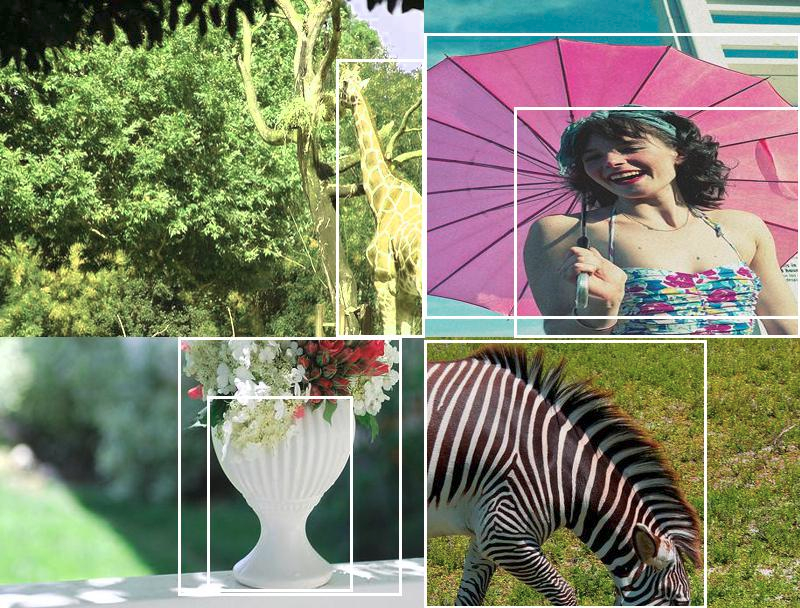

In [3]:
"""YOLOV5 dataset."""
from __future__ import division
import os
import multiprocessing
import random
import numpy as np
import cv2
from PIL import Image
import math
import numpy as np
from pycocotools.coco import COCO
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
from mindspore.dataset.vision import Normalize,HWC2CHW
from src.transforms import reshape_fn, MultiScaleTrans, PreprocessTrueBox


min_keypoints_per_image = 10
GENERATOR_PARALLEL_WORKER = 8


class DistributedSampler:
    """Distributed sampler."""

    def __init__(self, dataset_size, num_replicas=None, rank=None, shuffle=True):
        if num_replicas is None:
            print("***********Setting world_size to 1 since it is not passed in ******************")
            num_replicas = 1
        if rank is None:
            print("***********Setting rank to 0 since it is not passed in ******************")
            rank = 0
        self.dataset_size = dataset_size
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        self.num_samples = int(math.ceil(dataset_size * 1.0 / self.num_replicas))
        self.total_size = self.num_samples * self.num_replicas
        self.shuffle = shuffle

    def __iter__(self):
        # deterministically shuffle based on epoch
        if self.shuffle:
            indices = np.random.RandomState(seed=self.epoch).permutation(self.dataset_size)
            # np.array type. number from 0 to len(dataset_size)-1, used as
            # index of dataset
            indices = indices.tolist()
            self.epoch += 1
            # change to list type
        else:
            indices = list(range(self.dataset_size))

        # add extra samples to make it evenly divisible
        indices += indices[:(self.total_size - len(indices))]
        assert len(indices) == self.total_size

        # subsample
        indices = indices[self.rank:self.total_size:self.num_replicas]
        assert len(indices) == self.num_samples

        return iter(indices)

    def __len__(self):
        return self.num_samples

def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)


def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)


def has_valid_annotation(anno):
    """Check annotation file."""
    # if it's empty, there is no annotation
    if not anno:
        return False
    # if all boxes have close to zero area, there is no annotation
    if _has_only_empty_bbox(anno):
        return False
    # keypoints task have a slight different criteria for considering
    # if an annotation is valid
    if "keypoints" not in anno[0]:
        return True
    # for keypoint detection tasks, only consider valid images those
    # containing at least min_keypoints_per_image
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True
    return False


class COCOYoloDataset:
    """YOLOV5 Dataset for COCO."""
    def __init__(self, root, ann_file, remove_images_without_annotations=True,
                 filter_crowd_anno=True, is_training=True):
        self.coco = COCO(ann_file)
        self.root = root
        self.img_ids = list(sorted(self.coco.imgs.keys()))
        self.filter_crowd_anno = filter_crowd_anno
        self.is_training = is_training
        self.mosaic = True
        # filter images without any annotations
        if remove_images_without_annotations:
            img_ids = []
            for img_id in self.img_ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
                anno = self.coco.loadAnns(ann_ids)
                if has_valid_annotation(anno):
                    img_ids.append(img_id)
            self.img_ids = img_ids

        self.categories = {cat["id"]: cat["name"] for cat in self.coco.cats.values()}

        self.cat_ids_to_continuous_ids = {
            v: i for i, v in enumerate(self.coco.getCatIds())
        }
        self.continuous_ids_cat_ids = {
            v: k for k, v in self.cat_ids_to_continuous_ids.items()
        }
        self.count = 0

    def _mosaic_preprocess(self, index, input_size):
        labels4 = []
        s = 384
        self.mosaic_border = [-s // 2, -s // 2]
        yc, xc = [int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border]
        indices = [index] + [random.randint(0, len(self.img_ids) - 1) for _ in range(3)]
        for i, img_ids_index in enumerate(indices):
            coco = self.coco
            img_id = self.img_ids[img_ids_index]
            img_path = coco.loadImgs(img_id)[0]["file_name"]
            img = Image.open(os.path.join(self.root, img_path)).convert("RGB")
            img = np.array(img)
            h, w = img.shape[:2]

            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 128, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]

            padw = x1a - x1b
            padh = y1a - y1b

            ann_ids = coco.getAnnIds(imgIds=img_id)
            target = coco.loadAnns(ann_ids)
            # filter crowd annotations
            if self.filter_crowd_anno:
                annos = [anno for anno in target if anno["iscrowd"] == 0]
            else:
                annos = [anno for anno in target]

            target = {}
            boxes = [anno["bbox"] for anno in annos]
            target["bboxes"] = boxes

            classes = [anno["category_id"] for anno in annos]
            classes = [self.cat_ids_to_continuous_ids[cl] for cl in classes]
            target["labels"] = classes

            bboxes = target['bboxes']
            labels = target['labels']
            out_target = []

            for bbox, label in zip(bboxes, labels):
                tmp = []
                # convert to [x_min y_min x_max y_max]
                bbox = self._convetTopDown(bbox)
                tmp.extend(bbox)
                tmp.append(int(label))
                # tmp [x_min y_min x_max y_max, label]
                out_target.append(tmp)  # 这里out_target是label的实际宽高，对应于图片中的实际度量

            labels = out_target.copy()
            labels = np.array(labels)
            out_target = np.array(out_target)

            labels[:, 0] = out_target[:, 0] + padw
            labels[:, 1] = out_target[:, 1] + padh
            labels[:, 2] = out_target[:, 2] + padw
            labels[:, 3] = out_target[:, 3] + padh
            labels4.append(labels)

        if labels4:
            labels4 = np.concatenate(labels4, 0)
            np.clip(labels4[:, :4], 0, 2 * s, out=labels4[:, :4])  # use with random_perspective
        flag = np.array([1])
        return img4, labels4, input_size, flag

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            (img, target) (tuple): target is a dictionary contains "bbox", "segmentation" or "keypoints",
                generated by the image's annotation. img is a PIL image.
        """
        coco = self.coco
        img_id = self.img_ids[index]
        img_path = coco.loadImgs(img_id)[0]["file_name"]
        if not self.is_training:
            img = Image.open(os.path.join(self.root, img_path)).convert("RGB")
            return img, img_id

        input_size = [640, 640]
        if self.mosaic and random.random() < 0.5:
            return self._mosaic_preprocess(index, input_size)
        img = np.fromfile(os.path.join(self.root, img_path), dtype='int8')
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)
        # filter crowd annotations
        if self.filter_crowd_anno:
            annos = [anno for anno in target if anno["iscrowd"] == 0]
        else:
            annos = [anno for anno in target]

        target = {}
        boxes = [anno["bbox"] for anno in annos]
        target["bboxes"] = boxes

        classes = [anno["category_id"] for anno in annos]
        classes = [self.cat_ids_to_continuous_ids[cl] for cl in classes]
        target["labels"] = classes

        bboxes = target['bboxes']
        labels = target['labels']
        out_target = []
        for bbox, label in zip(bboxes, labels):
            tmp = []
            # convert to [x_min y_min x_max y_max]
            bbox = self._convetTopDown(bbox)
            tmp.extend(bbox)
            tmp.append(int(label))
            # tmp [x_min y_min x_max y_max, label]
            out_target.append(tmp)
        flag = np.array([0])
        return img, out_target, input_size, flag

    def __len__(self):
        return len(self.img_ids)

    def _convetTopDown(self, bbox):
        x_min = bbox[0]
        y_min = bbox[1]
        w = bbox[2]
        h = bbox[3]
        return [x_min, y_min, x_min+w, y_min+h]


def create_yolo_dataset(image_dir, anno_path, batch_size, device_num, rank,
                        config=args, is_training=True, shuffle=True):
    """Create dataset for YOLOV5."""
    cv2.setNumThreads(0)
    ds.config.set_enable_shared_mem(True)
    if is_training:
        filter_crowd = True
        remove_empty_anno = True
    else:
        filter_crowd = False
        remove_empty_anno = False

    yolo_dataset = COCOYoloDataset(root=image_dir, ann_file=anno_path, filter_crowd_anno=filter_crowd,
                                   remove_images_without_annotations=remove_empty_anno, is_training=is_training)
    distributed_sampler = DistributedSampler(len(yolo_dataset), device_num, rank, shuffle=shuffle)
    yolo_dataset.size = len(distributed_sampler)
    hwc_to_chw = HWC2CHW()

    args.dataset_size = len(yolo_dataset)

    cores = multiprocessing.cpu_count()
    num_parallel_workers = int(cores / device_num)
    # num_parallel_workers = 1
    if is_training:
        multi_scale_trans = MultiScaleTrans(args, device_num)
        yolo_dataset.transforms = multi_scale_trans

        dataset_column_names = ["image", "annotation", "input_size", "mosaic_flag"]
        output_column_names = ["image", "annotation", "bbox1", "bbox2", "bbox3",
                               "gt_box1", "gt_box2", "gt_box3"]
        map1_out_column_names = ["image", "annotation", "size"]
        map2_in_column_names = ["annotation", "size"]
        map2_out_column_names = ["annotation", "bbox1", "bbox2", "bbox3",
                                 "gt_box1", "gt_box2", "gt_box3"]

        dataset = ds.GeneratorDataset(yolo_dataset, column_names=dataset_column_names, sampler=distributed_sampler,
                                      python_multiprocessing=True, num_parallel_workers=min(4, num_parallel_workers))
        dataset = dataset.map(operations=multi_scale_trans, input_columns=dataset_column_names,
                              output_columns=map1_out_column_names, column_order=map1_out_column_names,
                              num_parallel_workers=min(12, num_parallel_workers), python_multiprocessing=True)
        dataset = dataset.map(operations=PreprocessTrueBox(args), input_columns=map2_in_column_names,
                              output_columns=map2_out_column_names, column_order=output_column_names,
                              num_parallel_workers=min(4, num_parallel_workers), python_multiprocessing=False)
        mean = [m * 255 for m in [0.485, 0.456, 0.406]]
        std = [s * 255 for s in [0.229, 0.224, 0.225]]
        dataset = dataset.map([Normalize(mean, std), hwc_to_chw],
                              num_parallel_workers=min(4, num_parallel_workers))

        def concatenate(images):
            images = np.concatenate((images[..., ::2, ::2], images[..., 1::2, ::2],
                                     images[..., ::2, 1::2], images[..., 1::2, 1::2]), axis=0)
            return images
        dataset = dataset.map(operations=concatenate, input_columns="image",
                              num_parallel_workers=min(4, num_parallel_workers))
        dataset = dataset.batch(batch_size, num_parallel_workers=min(4, num_parallel_workers), drop_remainder=True)
    else:
        dataset = ds.GeneratorDataset(yolo_dataset, column_names=["image", "img_id"],
                                      sampler=distributed_sampler)
        compose_map_func = (lambda image, img_id: reshape_fn(image, img_id, args))
        dataset = dataset.map(operations=compose_map_func, input_columns=["image", "img_id"],
                              output_columns=["image", "image_shape", "img_id"],
                              column_order=["image", "image_shape", "img_id"],
                              num_parallel_workers=8)
        dataset = dataset.map(operations=hwc_to_chw, input_columns=["image"], num_parallel_workers=8)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


> 2.4 模型实现 Backbone

>（1）Focus结构：其中比较关键是切片操作。比如下图的切片示意图，4 * 4 * 3的图像切片后变成2 * 2 * 12的特征图

>>>>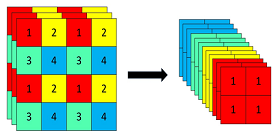
            
>（2）CSP结构： Yolov5中设计了两种CSP结构，CSP1_X结构应用于Backbone主干网络，另一种CSP2_X结构则应用于Neck中。

>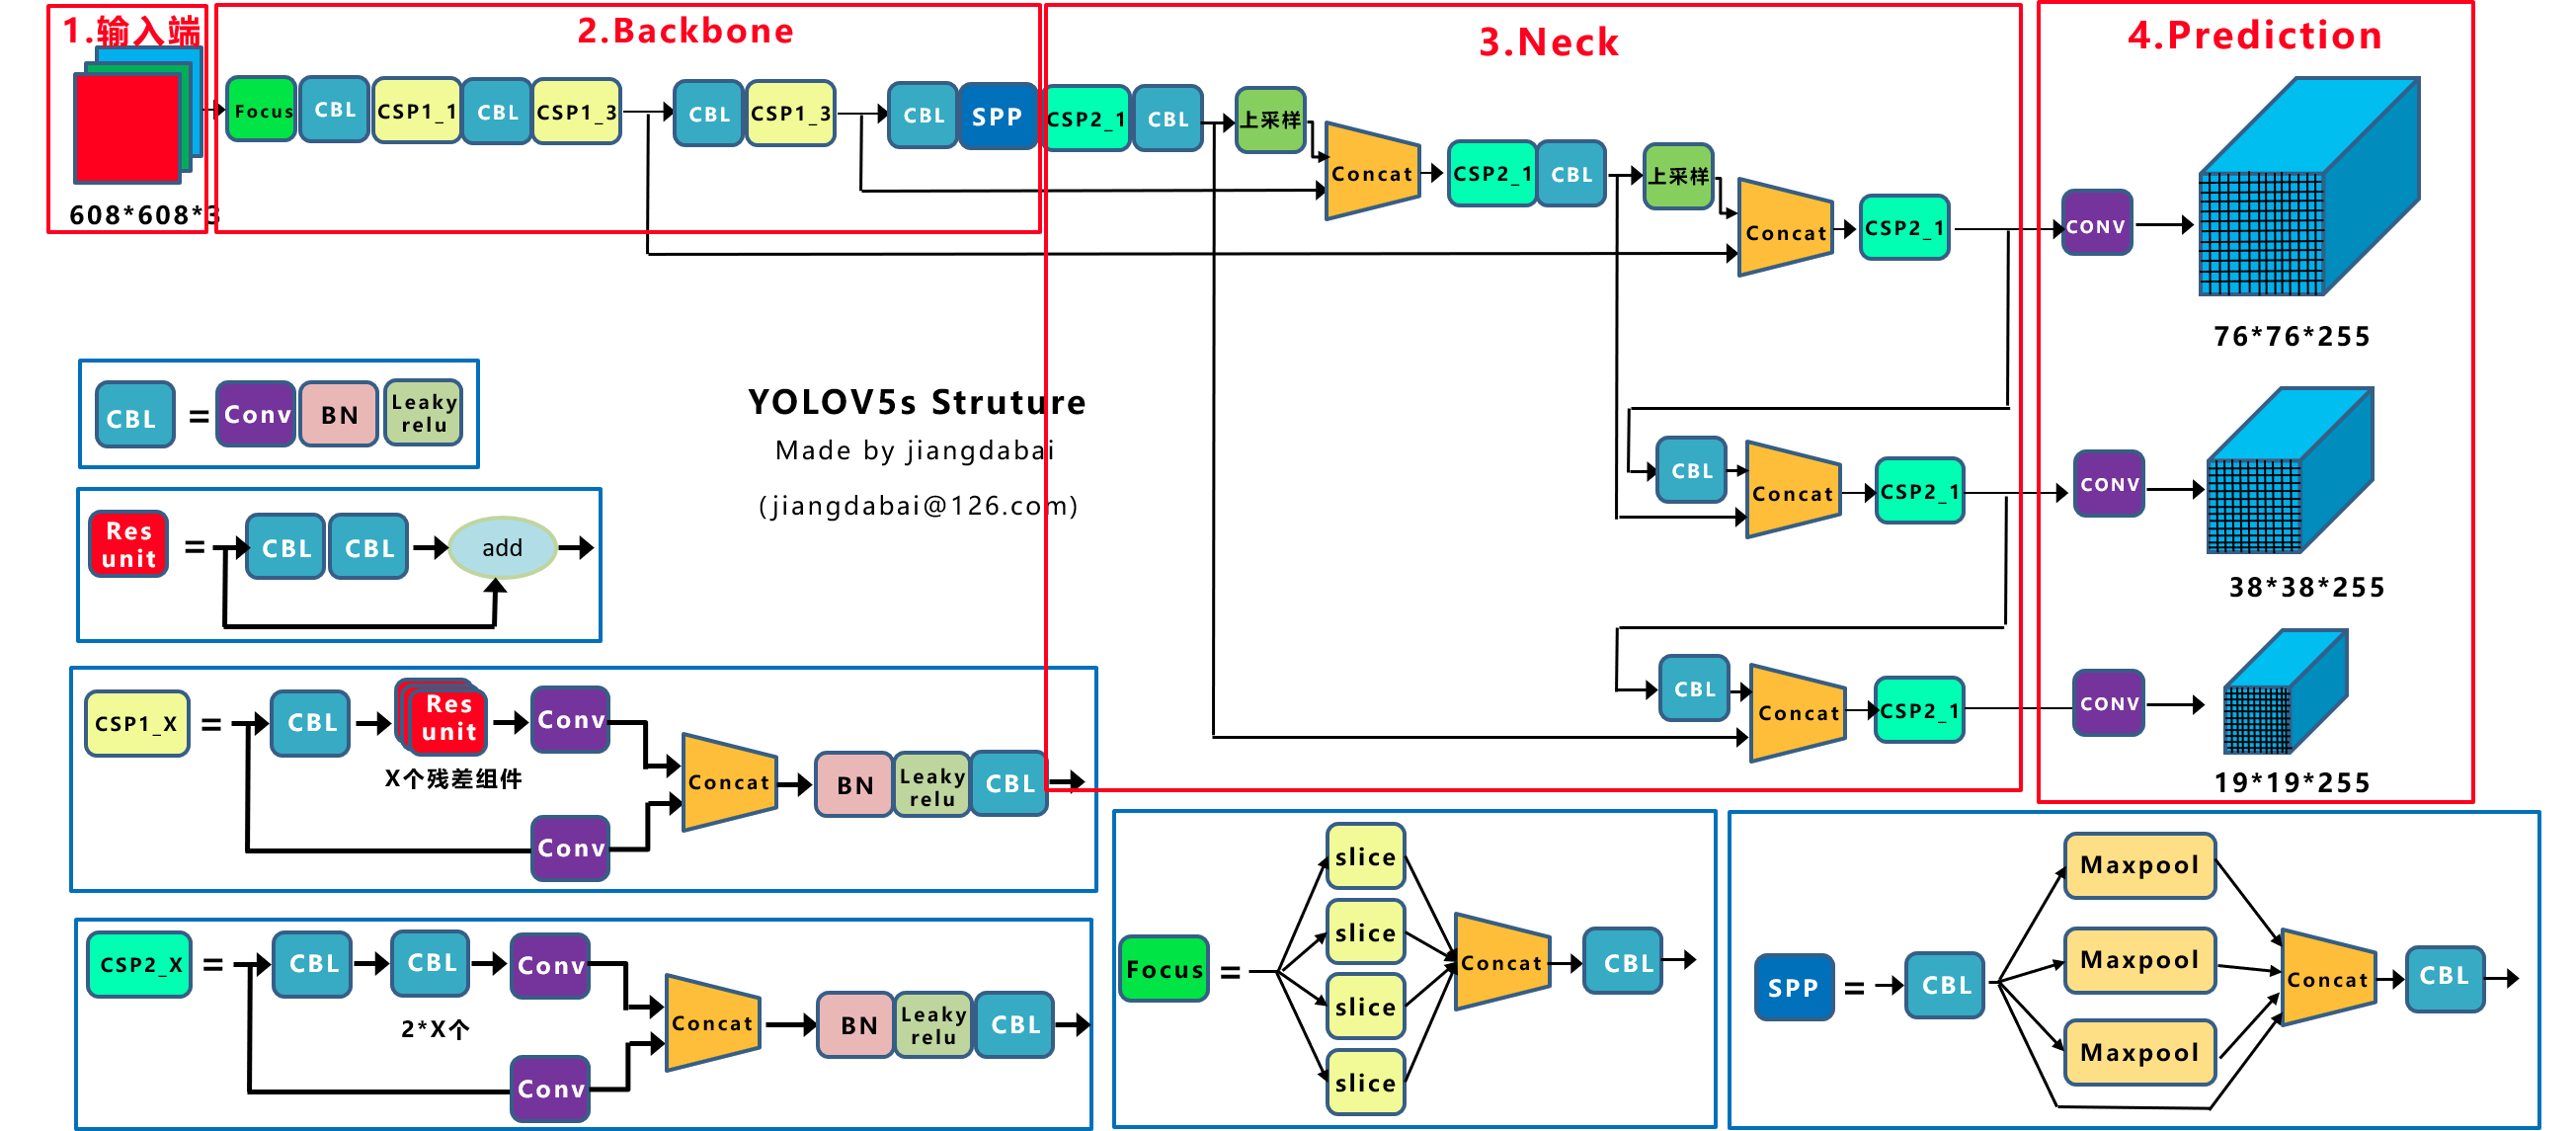

In [4]:
"""DarkNet model."""
import mindspore.nn as nn
import mindspore.ops as ops


class Bottleneck(nn.Cell):
    # Standard bottleneck
    # ch_in, ch_out, shortcut, groups, expansion
    def __init__(self, c1, c2, shortcut=True, e=0.5):
        super(Bottleneck, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c_, c2, 3, 1)
        self.add = shortcut and c1 == c2

    def construct(self, x):
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        out = c2
        if self.add:
            out = x + out
        return out


class BottleneckCSP(nn.Cell):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, e=0.5):
        super(BottleneckCSP, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c1, c_, 1, 1)
        self.conv3 = Conv(2 * c_, c2, 1)  # act=FReLU(c2)
        self.m = nn.SequentialCell(
            [Bottleneck(c_, c_, shortcut, e=1.0) for _ in range(n)])
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        c1 = self.conv1(x)
        c2 = self.m(c1)
        c3 = self.conv2(x)
        c4 = self.concat((c2, c3))
        c5 = self.conv3(c4)

        return c5


class SPP(nn.Cell):
    # Spatial pyramid pooling layer used in YOLOv3-SPP
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super(SPP, self).__init__()
        c_ = c1 // 2  # hidden channels
        self.conv1 = Conv(c1, c_, 1, 1)
        self.conv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)

        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=1, pad_mode='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=9, stride=1, pad_mode='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=13, stride=1, pad_mode='same')
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        c1 = self.conv1(x)
        m1 = self.maxpool1(c1)
        m2 = self.maxpool2(c1)
        m3 = self.maxpool3(c1)
        c4 = self.concat((c1, m1, m2, m3))
        c5 = self.conv2(c4)
        return c5


class Focus(nn.Cell):
    # Focus wh information into c-space
    def __init__(self, c1, c2, k=1, s=1, p=None, act=True):
        super(Focus, self).__init__()
        self.conv = Conv(c1 * 4, c2, k, s, p, act)

    def construct(self, x):
        c1 = self.conv(x)
        return c1


class SiLU(nn.Cell):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigmoid = ops.Sigmoid()

    def construct(self, x):
        return x * self.sigmoid(x)


def auto_pad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Cell):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None,
                 dilation=1,
                 alpha=0.1,
                 momentum=0.97,
                 eps=1e-3,
                 pad_mode="same",
                 act=True):  # ch_in, ch_out, kernel, stride, padding
        super(Conv, self).__init__()
        self.padding = auto_pad(k, p)
        self.pad_mode = None
        if self.padding == 0:
            self.pad_mode = 'same'
        elif self.padding == 1:
            self.pad_mode = 'pad'
        self.conv = nn.Conv2d(
            c1,
            c2,
            k,
            s,
            padding=self.padding,
            pad_mode=self.pad_mode,
            has_bias=False)
        self.bn = nn.BatchNorm2d(c2, momentum=momentum, eps=eps)
        self.act = SiLU() if act is True else (
            act if isinstance(act, nn.Cell) else ops.Identity())

    def construct(self, x):
        return self.act(self.bn(self.conv(x)))


class YOLOv5Backbone(nn.Cell):
    def __init__(self, shape):
        super(YOLOv5Backbone, self).__init__()
        self.focus = Focus(shape[0], shape[1], k=3, s=1)
        self.conv1 = Conv(shape[1], shape[2], k=3, s=2)
        self.CSP1 = BottleneckCSP(shape[2], shape[2], n=1 * shape[6])
        self.conv2 = Conv(shape[2], shape[3], k=3, s=2)
        self.CSP2 = BottleneckCSP(shape[3], shape[3], n=3 * shape[6])
        self.conv3 = Conv(shape[3], shape[4], k=3, s=2)
        self.CSP3 = BottleneckCSP(shape[4], shape[4], n=3 * shape[6])
        self.conv4 = Conv(shape[4], shape[5], k=3, s=2)
        self.spp = SPP(shape[5], shape[5], k=[5, 9, 13])
        self.CSP4 = BottleneckCSP(shape[5], shape[5], n=1 * shape[6], shortcut=False)

    def construct(self, x):
        """construct method"""
        c1 = self.focus(x)
        c2 = self.conv1(c1)
        c3 = self.CSP1(c2)
        c4 = self.conv2(c3)
        # out
        c5 = self.CSP2(c4)
        c6 = self.conv3(c5)
        # out
        c7 = self.CSP3(c6)
        c8 = self.conv4(c7)
        c9 = self.spp(c8)
        # out
        c10 = self.CSP4(c9)
        return c5, c7, c10


> 2.4 模型实现 Neck

  > 这是Pytorch版本的YOLOv5代码中对neck部分的配置文件，从配置文件中可以看出Neck部分的组件较为单一，基本上就由CBS（ConV）、Upsample、Concat和不带shortcut的CSP（C3)组成:
  
      [[-1, 1, Conv, [512, 1, 1]],
       [-1, 1, nn.Upsample, [None, 2, 'nearest']],
       [[-1, 6], 1, Concat, [1]],  # cat backbone P4
       [-1, 3, C3, [512, False]],  # 13

       [-1, 1, Conv, [256, 1, 1]],
       [-1, 1, nn.Upsample, [None, 2, 'nearest']],
       [[-1, 4], 1, Concat, [1]],  # cat backbone P3
       [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

       [-1, 1, Conv, [256, 3, 2]],
       [[-1, 14], 1, Concat, [1]],  # cat head P4
       [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

       [-1, 1, Conv, [512, 3, 2]],
       [[-1, 10], 1, Concat, [1]],  # cat head P5
       [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)
      ]
  > 另外，Neck的网络结构设计也是沿用了FPN+PAN的结构。FPN就是使用一种 自顶向下的侧边连接在所有尺度上构建出高级语义特征图，构造了特征金字塔的经典结构；PAN的结构也不稀奇，对于PAN，底层的目标信息已经非常模糊了，因此PAN又加入了自底向上的路线，弥补并加强了定位信息

      
> ![jupyter](./dataset/Neck.png) 



In [5]:
#  model
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops

class YoloBlock(nn.Cell):

    def __init__(self, in_channels, out_channels):
        super(YoloBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, has_bias=True)

    def construct(self, x):
        """construct method"""

        out = self.conv(x)
        return out

class YOLO(nn.Cell):
    def __init__(self, backbone, shape):
        super(YOLO, self).__init__()
        self.backbone = backbone
        self.out_channel = (80 + 5) * 3

        self.conv1 = Conv(shape[5], shape[4], k=1, s=1)
        self.CSP5 = BottleneckCSP(shape[5], shape[4], n=1*shape[6], shortcut=False)
        self.conv2 = Conv(shape[4], shape[3], k=1, s=1)
        self.CSP6 = BottleneckCSP(shape[4], shape[3], n=1*shape[6], shortcut=False)
        self.conv3 = Conv(shape[3], shape[3], k=3, s=2)
        self.CSP7 = BottleneckCSP(shape[4], shape[4], n=1*shape[6], shortcut=False)
        self.conv4 = Conv(shape[4], shape[4], k=3, s=2)
        self.CSP8 = BottleneckCSP(shape[5], shape[5], n=1*shape[6], shortcut=False)
        self.back_block1 = YoloBlock(shape[3], self.out_channel)
        self.back_block2 = YoloBlock(shape[4], self.out_channel)
        self.back_block3 = YoloBlock(shape[5], self.out_channel)

        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        
        img_height = x.shape[2] * 2
        img_width = x.shape[3] * 2

        feature_map1, feature_map2, feature_map3 = self.backbone(x)

        c1 = self.conv1(feature_map3)
        ups1 = ops.ResizeNearestNeighbor((img_height // 16, img_width // 16))(c1)
        c2 = self.concat((ups1, feature_map2))
        c3 = self.CSP5(c2)
        c4 = self.conv2(c3)
        ups2 = ops.ResizeNearestNeighbor((img_height // 8, img_width // 8))(c4)
        c5 = self.concat((ups2, feature_map1))
        # out
        c6 = self.CSP6(c5)
        c7 = self.conv3(c6)

        c8 = self.concat((c7, c4))
        # out
        c9 = self.CSP7(c8)
        c10 = self.conv4(c9)
        c11 = self.concat((c10, c1))
        # out
        c12 = self.CSP8(c11)
        small_object_output = self.back_block1(c6)
        medium_object_output = self.back_block2(c9)
        big_object_output = self.back_block3(c12)
        return small_object_output, medium_object_output, big_object_output


> 2.4 模型构建 backbone+Neck+Head

> Backbone作用：特征提取

> Neck作用：对特征进行一波混合与组合，并且把这些特征传递给预测层

> Head作用：进行最终的预测输出

![jupyter](./dataset/yolov5.png) 

In [6]:
# backbone+Neck+Head

class DetectionBlock(nn.Cell):


    def __init__(self, scale, is_training=True):
        super(DetectionBlock, self).__init__()
        if scale == 's':
            idx = (0, 1, 2)
            self.scale_x_y = 1.2
            self.offset_x_y = 0.1
        elif scale == 'm':
            idx = (3, 4, 5)
            self.scale_x_y = 1.1
            self.offset_x_y = 0.05
        elif scale == 'l':
            idx = (6, 7, 8)
            self.scale_x_y = 1.05
            self.offset_x_y = 0.025
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = ms.Tensor([args.anchor_scales[i] for i in idx], ms.float32)
        self.num_anchors_per_scale = 3
        self.num_attrib = 4+1+args.num_classes
        self.lambda_coord = 1

        self.sigmoid = nn.Sigmoid()
        self.reshape = ops.Reshape()
        self.tile = ops.Tile()
        self.concat = ops.Concat(axis=-1)
        self.pow = ops.Pow()
        self.transpose = ops.Transpose()
        self.exp = ops.Exp()
        self.conf_training = is_training

    def construct(self, x, input_shape):
        """construct method"""
        num_batch = x.shape[0]
        grid_size = x.shape[2:4]

        # Reshape and transpose the feature to [n, grid_size[0], grid_size[1], 3, num_attrib]
        prediction = self.reshape(x, (num_batch,
                                      self.num_anchors_per_scale,
                                      self.num_attrib,
                                      grid_size[0],
                                      grid_size[1]))
        prediction = self.transpose(prediction, (0, 3, 4, 1, 2))

        grid_x = ms.numpy.arange(grid_size[1])
        grid_y = ms.numpy.arange(grid_size[0])
        # Tensor of shape [grid_size[0], grid_size[1], 1, 1] representing the coordinate of x/y axis for each grid
        # [batch, gridx, gridy, 1, 1]
        grid_x = self.tile(self.reshape(grid_x, (1, 1, -1, 1, 1)), (1, grid_size[0], 1, 1, 1))
        grid_y = self.tile(self.reshape(grid_y, (1, -1, 1, 1, 1)), (1, 1, grid_size[1], 1, 1))
        # Shape is [grid_size[0], grid_size[1], 1, 2]
        grid = self.concat((grid_x, grid_y))

        box_xy = prediction[:, :, :, :, :2]
        box_wh = prediction[:, :, :, :, 2:4]
        box_confidence = prediction[:, :, :, :, 4:5]
        box_probs = prediction[:, :, :, :, 5:]

        # gridsize1 is x
        # gridsize0 is y
        box_xy = (self.scale_x_y * self.sigmoid(box_xy) - self.offset_x_y + grid) / \
                 ops.cast(ops.tuple_to_array((grid_size[1], grid_size[0])), ms.float32)
        # box_wh is w->h
        box_wh = self.exp(box_wh) * self.anchors / input_shape

        box_confidence = self.sigmoid(box_confidence)
        box_probs = self.sigmoid(box_probs)

        if self.conf_training:
            return prediction, box_xy, box_wh
        return self.concat((box_xy, box_wh, box_confidence, box_probs))

class YOLOV5(nn.Cell):
    """
    YOLOV5 network.

    Args:
        is_training: Bool. Whether train or not.

    Returns:
        Cell, cell instance of YOLOV5 neural network.

    Examples:
        YOLOV5s(True)
    """

    def __init__(self, is_training, version=0):
        super(YOLOV5, self).__init__()

        # YOLOv5 network
        self.shape = args.input_shape[version]
        self.feature_map = YOLO(backbone=YOLOv5Backbone(shape=self.shape), shape=self.shape)

        # prediction on the default anchor boxes
        self.detect_1 = DetectionBlock('l', is_training=is_training)
        self.detect_2 = DetectionBlock('m', is_training=is_training)
        self.detect_3 = DetectionBlock('s', is_training=is_training)

    def construct(self, x, input_shape):
        small_object_output, medium_object_output, big_object_output = self.feature_map(x)
        output_big = self.detect_1(big_object_output, input_shape)
        output_me = self.detect_2(medium_object_output, input_shape)
        output_small = self.detect_3(small_object_output, input_shape)
        # big is the final output which has smallest feature map
        return output_big, output_me, output_small

> 2.5 损失定义

  > YOLOv5一共有三种损失函数：

    分类损失cls_loss：计算锚框与对应的标定分类是否正确
    定位损失box_loss：预测框与标定框之间的误差（GIoU）
    置信度损失obj_loss：计算网络的置信度
    总的损失函数=分类损失+定位损失+置信度损失

    分类损失cls_loss和置信度损失obj_loss使用的是二元交叉熵损失函数BCEWithLogitsLoss计算。
    
    BCEwithlogitsloss = BCELoss + Sigmoid。
    
    定位损失box_loss使用的是GIoU loss(可以的话，也可以替换成CIoU，EIoU，SIoU等IoU损失)
    
   > IOU损失
   
       IOU Loss的定义是先求出预测框和真实框之间的交集和并集之比，再求负对数，但是在实际使用中我们常常将IOU Loss写成1-IOU。如果两个框重合则交并比等于1，Loss为0说明重合度非常高。IOU满足非负性、同一性、对称性、三角不等性，相比于L1/L2等损失函数还具有尺度不变性，不论box的尺度大小，输出的iou损失总是在0-1之间。所以能够较好的反映预测框与真实框的检测效果。
        IOU的公式如下：
    
   ![jupyter](./dataset/IOU公式.png)
   
       IOU的图示如下：
       
   ![jupyter](./dataset/IOU图示.png)
   
       普通IOU的优缺点很明显，优点：1、IOU具有尺度不变性2、满足非负性。同时，由于IOU并没有考虑框之间的距离，所以它的作为loss函数的时候也有相应的缺点：1、在A框与B框不重合的时候IOU为0，不能正确反映两者的距离大小。2. IoU无法精确的反映两者的重合度大小。
       GIOU是为克服IOU的缺点同时充分利用优点而提出的.(论文：Generalized Intersection over Union: A Metric and A Loss for Bounding Box Regression)
       
       GIOU的公式如下：
       
   ![jupyter](./dataset/GIOU公式.png)
   
       GIOU的图示如下：
     
   ![jupyter](./dataset/GIOU图示.png)
   
       计算过程如下：1.假设A为预测框，B为真实框，S是所有框的集合，2.不管A与B是否相交，C是包含A与B的最小框(包含A与B的最小凸闭合框)，C也属于S集合，3.首先计算IoU，A与B的交并比，4.再计算C框中没有A与B的面积，比上C框面积；5.IoU减去前面算出的比；得到GIoU。


In [7]:
# loss

class ConfidenceLoss(nn.Cell):
    """Loss for confidence."""

    def __init__(self):
        super(ConfidenceLoss, self).__init__()
        self.cross_entropy = ops.SigmoidCrossEntropyWithLogits()
        self.reduce_sum = ops.ReduceSum()

    def construct(self, object_mask, predict_confidence, ignore_mask):
        confidence_loss = self.cross_entropy(predict_confidence, object_mask)
        confidence_loss = object_mask * confidence_loss + (1 - object_mask) * confidence_loss * ignore_mask
        confidence_loss = self.reduce_sum(confidence_loss, ())
        return confidence_loss


class ClassLoss(nn.Cell):
    """Loss for classification."""

    def __init__(self):
        super(ClassLoss, self).__init__()
        self.cross_entropy = ops.SigmoidCrossEntropyWithLogits()
        self.reduce_sum = ops.ReduceSum()

    def construct(self, object_mask, predict_class, class_probs):
        class_loss = object_mask * self.cross_entropy(predict_class, class_probs)
        class_loss = self.reduce_sum(class_loss, ())
        return class_loss

class Iou(nn.Cell):
    """Calculate the iou of boxes"""
    def __init__(self):
        super(Iou, self).__init__()
        self.min = ops.Minimum()
        self.max = ops.Maximum()
        self.squeeze = ops.Squeeze(-1)

    def construct(self, box1, box2):
        """
        box1: pred_box [batch, gx, gy, anchors, 1,      4] ->4: [x_center, y_center, w, h]
        box2: gt_box   [batch, 1,  1,  1,       maxbox, 4]
        convert to topLeft and rightDown
        """
        box1_xy = box1[:, :, :, :, :, :2]
        box1_wh = box1[:, :, :, :, :, 2:4]
        box1_mins = box1_xy - box1_wh / ops.scalar_to_array(2.0) # topLeft
        box1_maxs = box1_xy + box1_wh / ops.scalar_to_array(2.0) # rightDown

        box2_xy = box2[:, :, :, :, :, :2]
        box2_wh = box2[:, :, :, :, :, 2:4]
        box2_mins = box2_xy - box2_wh / ops.scalar_to_array(2.0)
        box2_maxs = box2_xy + box2_wh / ops.scalar_to_array(2.0)

        intersect_mins = self.max(box1_mins, box2_mins)
        intersect_maxs = self.min(box1_maxs, box2_maxs)
        intersect_wh = self.max(intersect_maxs - intersect_mins, ops.scalar_to_array(0.0))
        # self.squeeze: for effiecient slice
        intersect_area = self.squeeze(intersect_wh[:, :, :, :, :, 0:1]) * \
                         self.squeeze(intersect_wh[:, :, :, :, :, 1:2])
        box1_area = self.squeeze(box1_wh[:, :, :, :, :, 0:1]) * \
                    self.squeeze(box1_wh[:, :, :, :, :, 1:2])
        box2_area = self.squeeze(box2_wh[:, :, :, :, :, 0:1]) * \
                    self.squeeze(box2_wh[:, :, :, :, :, 1:2])
        iou = intersect_area / (box1_area + box2_area - intersect_area)
        # iou : [batch, gx, gy, anchors, maxboxes]
        return iou
    
class GIou(nn.Cell):
    """Calculating giou"""
    def __init__(self):
        super(GIou, self).__init__()
        self.reshape = ops.Reshape()
        self.min = ops.Minimum()
        self.max = ops.Maximum()
        self.concat = ops.Concat(axis=1)
        self.mean = ops.ReduceMean()
        self.div = ops.RealDiv()
        self.eps = 0.000001

    def construct(self, box_p, box_gt):
        """construct method"""
        box_p_area = (box_p[..., 2:3] - box_p[..., 0:1]) * (box_p[..., 3:4] - box_p[..., 1:2])
        box_gt_area = (box_gt[..., 2:3] - box_gt[..., 0:1]) * (box_gt[..., 3:4] - box_gt[..., 1:2])
        x_1 = self.max(box_p[..., 0:1], box_gt[..., 0:1])
        x_2 = self.min(box_p[..., 2:3], box_gt[..., 2:3])
        y_1 = self.max(box_p[..., 1:2], box_gt[..., 1:2])
        y_2 = self.min(box_p[..., 3:4], box_gt[..., 3:4])
        intersection = (y_2 - y_1) * (x_2 - x_1)
        xc_1 = self.min(box_p[..., 0:1], box_gt[..., 0:1])
        xc_2 = self.max(box_p[..., 2:3], box_gt[..., 2:3])
        yc_1 = self.min(box_p[..., 1:2], box_gt[..., 1:2])
        yc_2 = self.max(box_p[..., 3:4], box_gt[..., 3:4])
        c_area = (xc_2 - xc_1) * (yc_2 - yc_1)
        union = box_p_area + box_gt_area - intersection
        union = union + self.eps
        c_area = c_area + self.eps
        iou = self.div(ops.cast(intersection, ms.float32), ops.cast(union, ms.float32))
        res_mid0 = c_area - union
        res_mid1 = self.div(ops.cast(res_mid0, ms.float32), ops.cast(c_area, ms.float32))
        giou = iou - res_mid1
        giou = ops.clip_by_value(giou, -1.0, 1.0)
        return giou


def xywh2x1y1x2y2(box_xywh):
    boxes_x1 = box_xywh[..., 0:1] - box_xywh[..., 2:3] / 2
    boxes_y1 = box_xywh[..., 1:2] - box_xywh[..., 3:4] / 2
    boxes_x2 = box_xywh[..., 0:1] + box_xywh[..., 2:3] / 2
    boxes_y2 = box_xywh[..., 1:2] + box_xywh[..., 3:4] / 2
    boxes_x1y1x2y2 = ops.Concat(-1)((boxes_x1, boxes_y1, boxes_x2, boxes_y2))

    return boxes_x1y1x2y2


class YoloLossBlock(nn.Cell):
    """
    Loss block cell of YOLOV5 network.
    """
    def __init__(self, scale, config=args):
        super(YoloLossBlock, self).__init__()
        self.config = config
        if scale == 's':
            # anchor mask
            idx = (0, 1, 2)
        elif scale == 'm':
            idx = (3, 4, 5)
        elif scale == 'l':
            idx = (6, 7, 8)
        else:
            raise KeyError("Invalid scale value for DetectionBlock")
        self.anchors = ms.Tensor([self.config.anchor_scales[i] for i in idx], ms.float32)
        self.ignore_threshold = ms.Tensor(self.config.ignore_threshold, ms.float32)
        self.concat = ops.Concat(axis=-1)
        self.iou = Iou()
        self.reduce_max = ops.ReduceMax(keep_dims=False)
        self.confidence_loss = ConfidenceLoss()
        self.class_loss = ClassLoss()

        self.reduce_sum = ops.ReduceSum()
        self.select = ops.Select()
        self.equal = ops.Equal()
        self.reshape = ops.Reshape()
        self.expand_dims = ops.ExpandDims()
        self.ones_like = ops.OnesLike()
        self.log = ops.Log()
        self.tuple_to_array = ops.TupleToArray()
        self.g_iou = GIou()

    def construct(self, prediction, pred_xy, pred_wh, y_true, gt_box, input_shape):
        """
        prediction : origin output from yolo
        pred_xy: (sigmoid(xy)+grid)/grid_size
        pred_wh: (exp(wh)*anchors)/input_shape
        y_true : after normalize
        gt_box: [batch, maxboxes, xyhw] after normalize
        """
        object_mask = y_true[:, :, :, :, 4:5]
        class_probs = y_true[:, :, :, :, 5:]
        true_boxes = y_true[:, :, :, :, :4]

        grid_shape = prediction.shape[1:3]
        grid_shape = ops.cast(self.tuple_to_array(grid_shape[::-1]), ms.float32)

        pred_boxes = self.concat((pred_xy, pred_wh))
        true_wh = y_true[:, :, :, :, 2:4]
        true_wh = self.select(self.equal(true_wh, 0.0),
                              self.ones_like(true_wh),
                              true_wh)
        true_wh = self.log(true_wh / self.anchors * input_shape)
        # 2-w*h for large picture, use small scale, since small obj need more precise
        box_loss_scale = 2 - y_true[:, :, :, :, 2:3] * y_true[:, :, :, :, 3:4]

        gt_shape = gt_box.shape
        gt_box = self.reshape(gt_box, (gt_shape[0], 1, 1, 1, gt_shape[1], gt_shape[2]))

        # add one more dimension for broadcast
        iou = self.iou(self.expand_dims(pred_boxes, -2), gt_box)
        # gt_box is x,y,h,w after normalize
        # [batch, grid[0], grid[1], num_anchor, num_gt]
        best_iou = self.reduce_max(iou, -1)
        # [batch, grid[0], grid[1], num_anchor]

        # ignore_mask IOU too small
        ignore_mask = best_iou < self.ignore_threshold
        ignore_mask = ops.cast(ignore_mask, ms.float32)
        ignore_mask = self.expand_dims(ignore_mask, -1)
        # ignore_mask backpro will cause a lot maximunGrad and minimumGrad time consume.
        # so we turn off its gradient
        ignore_mask = ops.stop_gradient(ignore_mask)

        confidence_loss = self.confidence_loss(object_mask, prediction[:, :, :, :, 4:5], ignore_mask)
        class_loss = self.class_loss(object_mask, prediction[:, :, :, :, 5:], class_probs)

        object_mask_me = self.reshape(object_mask, (-1, 1))  # [8, 72, 72, 3, 1]
        box_loss_scale_me = self.reshape(box_loss_scale, (-1, 1))
        pred_boxes_me = xywh2x1y1x2y2(pred_boxes)
        pred_boxes_me = self.reshape(pred_boxes_me, (-1, 4))
        true_boxes_me = xywh2x1y1x2y2(true_boxes)
        true_boxes_me = self.reshape(true_boxes_me, (-1, 4))
        c_iou = self.g_iou(pred_boxes_me, true_boxes_me)
        c_iou_loss = object_mask_me * box_loss_scale_me * (1 - c_iou)
        c_iou_loss_me = self.reduce_sum(c_iou_loss, ())
        loss = c_iou_loss_me * 4 + confidence_loss + class_loss
        batch_size = prediction.shape[0]
        return loss / batch_size

class YoloWithLossCell(nn.Cell):
    """YOLOV5 loss."""
    def __init__(self, network):
        super(YoloWithLossCell, self).__init__()
        self.yolo_network = network
        self.config = args
        self.loss_big = YoloLossBlock('l', self.config)
        self.loss_me = YoloLossBlock('m', self.config)
        self.loss_small = YoloLossBlock('s', self.config)
        self.tenser_to_array = ops.TupleToArray()

    def construct(self, x, y_true_0, y_true_1, y_true_2, gt_0, gt_1, gt_2, input_shape):
        input_shape = x.shape[2:4]
        input_shape = ops.cast(self.tenser_to_array(input_shape) * 2, ms.float32)

        yolo_out = self.yolo_network(x, input_shape)
        loss_l = self.loss_big(*yolo_out[0], y_true_0, gt_0, input_shape)
        loss_m = self.loss_me(*yolo_out[1], y_true_1, gt_1, input_shape)
        loss_s = self.loss_small(*yolo_out[2], y_true_2, gt_2, input_shape)
        return loss_l + loss_m + loss_s * 0.2



> 2.6 学习率
 
 > 提供了4种不同的学习率形式选择，分别是：exponential，cosine_annealing，cosine_annealing_V2，cosine_annealing_sample。这里选择的是cosine_annealing


In [8]:
"""Learning rate scheduler."""
import math
from collections import Counter

import numpy as np


def linear_warmup_lr(current_step, warmup_steps, base_lr, init_lr):
    """Linear learning rate."""
    lr_inc = (float(base_lr) - float(init_lr)) / float(warmup_steps)
    lr = float(init_lr) + lr_inc * current_step
    return lr


def warmup_step_lr(lr, lr_epochs, steps_per_epoch, warmup_epochs, max_epoch, gamma=0.1):
    """Warmup step learning rate."""
    base_lr = lr
    warmup_init_lr = 0
    total_steps = int(max_epoch * steps_per_epoch)
    warmup_steps = int(warmup_epochs * steps_per_epoch)
    milestones = lr_epochs
    milestones_steps = []
    for milestone in milestones:
        milestones_step = milestone * steps_per_epoch
        milestones_steps.append(milestones_step)

    lr_each_step = []
    lr = base_lr
    milestones_steps_counter = Counter(milestones_steps)
    for i in range(total_steps):
        if i < warmup_steps:
            lr = linear_warmup_lr(i + 1, warmup_steps, base_lr, warmup_init_lr)
        else:
            lr = lr * gamma**milestones_steps_counter[i]
        lr_each_step.append(lr)

    return np.array(lr_each_step).astype(np.float32)


def multi_step_lr(lr, milestones, steps_per_epoch, max_epoch, gamma=0.1):
    return warmup_step_lr(lr, milestones, steps_per_epoch, 0, max_epoch, gamma=gamma)


def step_lr(lr, epoch_size, steps_per_epoch, max_epoch, gamma=0.1):
    lr_epochs = []
    for i in range(1, max_epoch):
        if i % epoch_size == 0:
            lr_epochs.append(i)
    return multi_step_lr(lr, lr_epochs, steps_per_epoch, max_epoch, gamma=gamma)


def warmup_cosine_annealing_lr(lr, steps_per_epoch, warmup_epochs, max_epoch, T_max, eta_min=0):
    """Cosine annealing learning rate."""
    base_lr = lr
    warmup_init_lr = 0
    total_steps = int(max_epoch * steps_per_epoch)
    warmup_steps = int(warmup_epochs * steps_per_epoch)

    lr_each_step = []
    for i in range(total_steps):
        last_epoch = i // steps_per_epoch
        if i < warmup_steps:
            lr = linear_warmup_lr(i + 1, warmup_steps, base_lr, warmup_init_lr)
        else:
            lr = eta_min + (base_lr - eta_min) * (1. + math.cos(math.pi * last_epoch / T_max)) / 2
        lr_each_step.append(lr)

    return np.array(lr_each_step).astype(np.float32)


def warmup_cosine_annealing_lr_V2(lr, steps_per_epoch, warmup_epochs, max_epoch, T_max, eta_min=0):
    """Cosine annealing learning rate V2."""
    base_lr = lr
    warmup_init_lr = 0
    total_steps = int(max_epoch * steps_per_epoch)
    warmup_steps = int(warmup_epochs * steps_per_epoch)

    last_lr = 0
    last_epoch_V1 = 0

    T_max_V2 = int(max_epoch * 1 / 3)

    lr_each_step = []
    for i in range(total_steps):
        last_epoch = i // steps_per_epoch
        if i < warmup_steps:
            lr = linear_warmup_lr(i + 1, warmup_steps, base_lr, warmup_init_lr)
        else:
            if i < total_steps * 2 / 3:
                lr = eta_min + (base_lr - eta_min) * (1. + math.cos(math.pi * last_epoch / T_max)) / 2
                last_lr = lr
                last_epoch_V1 = last_epoch
            else:
                base_lr = last_lr
                last_epoch = last_epoch - last_epoch_V1
                lr = eta_min + (base_lr - eta_min) * (1. + math.cos(math.pi * last_epoch / T_max_V2)) / 2

        lr_each_step.append(lr)
    return np.array(lr_each_step).astype(np.float32)


def warmup_cosine_annealing_lr_sample(lr, steps_per_epoch, warmup_epochs, max_epoch, T_max, eta_min=0):
    """Warmup cosine annealing learning rate."""
    start_sample_epoch = 60
    step_sample = 2
    tobe_sampled_epoch = 60
    end_sampled_epoch = start_sample_epoch + step_sample * tobe_sampled_epoch
    max_sampled_epoch = max_epoch + tobe_sampled_epoch
    T_max = max_sampled_epoch

    base_lr = lr
    warmup_init_lr = 0
    total_steps = int(max_epoch * steps_per_epoch)
    total_sampled_steps = int(max_sampled_epoch * steps_per_epoch)
    warmup_steps = int(warmup_epochs * steps_per_epoch)

    lr_each_step = []

    for i in range(total_sampled_steps):
        last_epoch = i // steps_per_epoch
        if last_epoch in range(start_sample_epoch, end_sampled_epoch, step_sample):
            continue
        if i < warmup_steps:
            lr = linear_warmup_lr(i + 1, warmup_steps, base_lr, warmup_init_lr)
        else:
            lr = eta_min + (base_lr - eta_min) * (1. + math.cos(math.pi * last_epoch / T_max)) / 2
        lr_each_step.append(lr)

    assert total_steps == len(lr_each_step)
    return np.array(lr_each_step).astype(np.float32)


def get_lr(args, steps_per_epoch):
    """generate learning rate."""
    if args.lr_scheduler == 'exponential':
        lr = warmup_step_lr(args.lr, args.lr_epochs, steps_per_epoch, args.warmup_epochs, args.max_epoch,
                            gamma=args.lr_gamma)
    elif args.lr_scheduler == 'cosine_annealing':
        lr = warmup_cosine_annealing_lr(args.lr, steps_per_epoch, args.warmup_epochs,
                                        args.max_epoch, args.T_max, args.eta_min)
    elif args.lr_scheduler == 'cosine_annealing_V2':
        lr = warmup_cosine_annealing_lr_V2(args.lr, steps_per_epoch, args.warmup_epochs,
                                           args.max_epoch, args.T_max, args.eta_min)
    elif args.lr_scheduler == 'cosine_annealing_sample':
        lr = warmup_cosine_annealing_lr_sample(args.lr, steps_per_epoch, args.warmup_epochs,
                                               args.max_epoch, args.T_max, args.eta_min)
    else:
        raise NotImplementedError(args.lr_scheduler)
    return lr



> 2.7 模型训练

In [9]:
import os
import time
import mindspore as ms
import mindspore.nn as nn
import mindspore.communication as comm


from src.logger import get_logger
from src.util import AverageMeter, get_param_groups, cpu_affinity
from src.initializer import default_recurisive_init, load_yolov5_params

ms.set_seed(1)

def train_preprocess():
    if args.lr_scheduler == 'cosine_annealing' and args.max_epoch > args.T_max:
        args.T_max = args.max_epoch

    args.lr_epochs = list(map(int, args.lr_epochs.split(',')))
    args.data_root = os.path.join(args.data_dir, 'train2017')
    args.annFile = os.path.join(args.data_dir, 'annotations/instances_train2017.json')
    if args.pretrained_checkpoint:
        args.pretrained_checkpoint = args.pretrained_checkpoint
    args.device_id = int(os.getenv('DEVICE_ID', '1'))
    ms.set_context(mode=ms.GRAPH_MODE, device_target=args.device_target)

    if args.is_distributed:
        # init distributed
        init_distribute()

    # for promoting performance in GPU device
    if args.device_target == "GPU" and args.bind_cpu:
        cpu_affinity(args.rank, min(args.group_size, 8))
    
    # logger module is managed by config, it is used in other function. e.x. config.logger.info("xxx")
    args.logger = get_logger(args.output_dir, args.rank)



def run_train():
    train_preprocess()

    loss_meter = AverageMeter('loss')
    dict_version = {'yolov5s': 0, 'yolov5m': 1, 'yolov5l': 2, 'yolov5x': 3}
    network = YOLOV5(is_training=True, version=dict_version[args.yolov5_version])
    # default is kaiming-normal
    default_recurisive_init(network)
    load_yolov5_params(args, network)
    network = YoloWithLossCell(network)

    ds = create_yolo_dataset(image_dir=args.data_root, anno_path=args.annFile, is_training=True,
                             batch_size=args.per_batch_size, device_num=args.group_size,
                             rank=args.rank, config=args)
    args.logger.info('Finish loading dataset')

    steps_per_epoch = ds.get_dataset_size()
    lr = get_lr(args, steps_per_epoch)
    opt = nn.Momentum(params=get_param_groups(network), momentum=args.momentum, learning_rate=ms.Tensor(lr),
                      weight_decay=args.weight_decay, loss_scale=args.loss_scale)
    network = nn.TrainOneStepCell(network, opt, args.loss_scale // 2)
    network.set_train()

    data_loader = ds.create_tuple_iterator(do_copy=False)
    first_step = True
    t_end = time.time()

    for epoch_idx in range(args.max_epoch):
        for step_idx, data in enumerate(data_loader):
            images = data[0]
            input_shape = images.shape[2:4]
            input_shape = ms.Tensor(tuple(input_shape[::-1]), ms.float32)
            loss = network(images, data[2], data[3], data[4], data[5], data[6],
                           data[7], input_shape)
            loss_meter.update(loss.asnumpy())

            # it is used for loss, performance output per config.log_interval steps.
            if (epoch_idx * steps_per_epoch + step_idx) % args.log_interval == 0:
                time_used = time.time() - t_end
                if first_step:
                    fps = args.per_batch_size * args.group_size / time_used
                    per_step_time = time_used * 1000
                    first_step = False
                else:
                    fps = args.per_batch_size * args.log_interval * args.group_size / time_used
                    per_step_time = time_used / args.log_interval * 1000
                args.logger.info('epoch[{}], iter[{}], {}, fps:{:.2f} imgs/sec, '
                                   'lr:{}, per step time: {}ms'.format(
                                    epoch_idx + 1, step_idx + 1, loss_meter, fps, 
                                    lr[epoch_idx * steps_per_epoch + step_idx], per_step_time))
                t_end = time.time()
                loss_meter.reset()
        if args.rank == 0:
            ckpt_name = os.path.join(args.output_dir, "yolov5_{}_{}.ckpt".format(epoch_idx + 1, steps_per_epoch))
            ms.save_checkpoint(network, ckpt_name)

    args.logger.info('==========end training===============')


if __name__ == "__main__":
    run_train()



{}
==== 0/1 ==== bind cpu: [0, 1, 2, 3, 4, 5, 6, 7]


[WARNING] ME(23691:140695503083328,MainProcess):2022-11-07-04:49:04.818.676 [mindspore/dataset/core/config.py:635] The shared memory is on, multiprocessing performance will be improved. Note: the required shared memory can't exceeds 80% of the available shared memory.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2022-11-07 04:49:05,439:INFO:Finish loading dataset
2022-11-07 04:49:29,778:INFO:epoch[1], iter[1], loss:8635.478516, fps:0.37 imgs/sec, lr:2.0833333110203966e-05, per step time: 21452.398538589478ms
2022-11-07 04:49:33,048:INFO:epoch[2], iter[1], loss:5757.334432, fps:14.69 imgs/sec, lr:0.00014583332813344896, per step time: 544.7433789571127ms
2022-11-07 04:49:36,138:INFO:epoch[3], iter[1], loss:1525.723979, fps:15.54 imgs/sec, lr:0.00027083331951871514, per step time: 514.9061679840088ms
2022-11-07 04:49:39,290:INFO:epoch[4], iter[1], loss:1448.094177, fps:15.23 imgs/sec, lr:0.0003958333400078118, per step time: 525.1760880152384ms
2022-11-07 04:49:42,360:INFO:epoch[5], iter[1], loss:1515.209727, fps:15.64 imgs/sec, lr:0.0004997806972824037, per step time: 511.47735118865967ms
2022-11-07 04:49:45,438:INFO:epoch[6], iter[1], loss:1247.172221, fps:15.60 imgs/sec, lr:0.0004996573552489281, per step time:

2022-11-07 04:52:19,986:INFO:epoch[56], iter[1], loss:355.191078, fps:15.14 imgs/sec, lr:0.0004596676444634795, per step time: 528.441309928894ms
2022-11-07 04:52:23,274:INFO:epoch[57], iter[1], loss:414.892309, fps:14.60 imgs/sec, lr:0.00045823032269254327, per step time: 547.8837092717489ms
2022-11-07 04:52:26,418:INFO:epoch[58], iter[1], loss:381.324132, fps:15.27 imgs/sec, lr:0.0004567701544146985, per step time: 523.8329569498698ms
2022-11-07 04:52:29,524:INFO:epoch[59], iter[1], loss:365.411352, fps:15.46 imgs/sec, lr:0.0004552873142529279, per step time: 517.4691677093506ms
2022-11-07 04:52:32,605:INFO:epoch[60], iter[1], loss:388.237473, fps:15.58 imgs/sec, lr:0.0004537819477263838, per step time: 513.4329398473104ms
2022-11-07 04:52:35,734:INFO:epoch[61], iter[1], loss:335.316437, fps:15.34 imgs/sec, lr:0.0004522542585618794, per step time: 521.3543176651001ms
2022-11-07 04:52:38,773:INFO:epoch[62], iter[1], loss:410.190720, fps:15.80 imgs/sec, lr:0.0004507043631747365, per st

2022-11-07 04:55:17,898:INFO:epoch[112], iter[1], loss:293.797155, fps:14.96 imgs/sec, lr:0.000349286972777918, per step time: 534.8495244979858ms
2022-11-07 04:55:21,087:INFO:epoch[113], iter[1], loss:363.579051, fps:15.06 imgs/sec, lr:0.0003468788927420974, per step time: 531.320333480835ms
2022-11-07 04:55:24,134:INFO:epoch[114], iter[1], loss:302.780858, fps:15.76 imgs/sec, lr:0.00034446018980816007, per step time: 507.6932509740194ms
2022-11-07 04:55:27,364:INFO:epoch[115], iter[1], loss:320.301458, fps:14.87 imgs/sec, lr:0.00034203112591058016, per step time: 538.1094614664713ms
2022-11-07 04:55:30,698:INFO:epoch[116], iter[1], loss:311.651520, fps:14.40 imgs/sec, lr:0.0003395919920876622, per step time: 555.4742018381754ms
2022-11-07 04:55:33,976:INFO:epoch[117], iter[1], loss:365.847015, fps:14.65 imgs/sec, lr:0.0003371430211700499, per step time: 546.1826324462891ms
2022-11-07 04:55:37,256:INFO:epoch[118], iter[1], loss:284.048299, fps:14.64 imgs/sec, lr:0.0003346844750922173,

2022-11-07 04:58:19,965:INFO:epoch[168], iter[1], loss:322.081187, fps:14.56 imgs/sec, lr:0.00020572882203850895, per step time: 549.4547684987386ms
2022-11-07 04:58:23,275:INFO:epoch[169], iter[1], loss:332.497981, fps:14.51 imgs/sec, lr:0.00020315467554610223, per step time: 551.4965852101644ms
2022-11-07 04:58:26,489:INFO:epoch[170], iter[1], loss:298.625603, fps:14.94 imgs/sec, lr:0.0002005856658797711, per step time: 535.6348752975464ms
2022-11-07 04:58:29,820:INFO:epoch[171], iter[1], loss:306.347262, fps:14.42 imgs/sec, lr:0.00019802208407782018, per step time: 554.8820892969767ms
2022-11-07 04:58:33,014:INFO:epoch[172], iter[1], loss:288.888774, fps:15.03 imgs/sec, lr:0.00019546419207472354, per step time: 532.1563482284546ms
2022-11-07 04:58:36,294:INFO:epoch[173], iter[1], loss:291.411840, fps:14.64 imgs/sec, lr:0.00019291228090878576, per step time: 546.5766588846842ms
2022-11-07 04:58:39,519:INFO:epoch[174], iter[1], loss:354.452108, fps:14.89 imgs/sec, lr:0.000190366641618

2022-11-07 05:01:20,245:INFO:epoch[224], iter[1], loss:301.296789, fps:14.69 imgs/sec, lr:7.696420652791858e-05, per step time: 544.6098248163859ms
2022-11-07 05:01:23,566:INFO:epoch[225], iter[1], loss:295.032883, fps:14.46 imgs/sec, lr:7.508416456403211e-05, per step time: 553.2041390736898ms
2022-11-07 05:01:26,862:INFO:epoch[226], iter[1], loss:308.999914, fps:14.57 imgs/sec, lr:7.322330202441663e-05, per step time: 549.1107304890951ms
2022-11-07 05:01:30,013:INFO:epoch[227], iter[1], loss:284.904007, fps:15.24 imgs/sec, lr:7.138182991184294e-05, per step time: 525.0473817189535ms
2022-11-07 05:01:33,359:INFO:epoch[228], iter[1], loss:297.982755, fps:14.35 imgs/sec, lr:6.955994467716664e-05, per step time: 557.5353304545084ms
2022-11-07 05:01:36,432:INFO:epoch[229], iter[1], loss:313.034098, fps:15.62 imgs/sec, lr:6.77578427712433e-05, per step time: 512.1086835861206ms
2022-11-07 05:01:39,664:INFO:epoch[230], iter[1], loss:307.471481, fps:14.86 imgs/sec, lr:6.597572792088613e-05, 

2022-11-07 05:04:21,278:INFO:epoch[280], iter[1], loss:270.010470, fps:14.35 imgs/sec, lr:6.020809451001696e-06, per step time: 557.5947761535645ms
2022-11-07 05:04:24,533:INFO:epoch[281], iter[1], loss:309.024882, fps:14.75 imgs/sec, lr:5.4631000239169225e-06, per step time: 542.3045555750529ms
2022-11-07 05:04:27,865:INFO:epoch[282], iter[1], loss:290.754951, fps:14.41 imgs/sec, lr:4.932206138619222e-06, per step time: 555.0909042358398ms
2022-11-07 05:04:31,186:INFO:epoch[283], iter[1], loss:296.072820, fps:14.46 imgs/sec, lr:4.42818736701156e-06, per step time: 553.4310340881348ms
2022-11-07 05:04:34,469:INFO:epoch[284], iter[1], loss:289.401362, fps:14.63 imgs/sec, lr:3.951097824028693e-06, per step time: 546.9815731048584ms
2022-11-07 05:04:37,794:INFO:epoch[285], iter[1], loss:273.344383, fps:14.44 imgs/sec, lr:3.5009907151106745e-06, per step time: 553.9700190226237ms
2022-11-07 05:04:40,947:INFO:epoch[286], iter[1], loss:253.896357, fps:15.23 imgs/sec, lr:3.0779149255977245e-0

> 2.8 模型测试

In [13]:
import os
import time

import numpy as np

import mindspore as ms
# from model_utils.config import config
# from src.yolo import YOLOV5
from src.logger import get_logger
from src.util import DetectionEngine
# from src.yolo_dataset import create_yolo_dataset

from src.util import DetectionEngine

def eval_preprocess():
    args.data_root = os.path.join(args.data_dir, 'val2017')
    args.ann_file = os.path.join(args.data_dir, 'annotations/instances_val2017.json')
    ms.set_context(mode=ms.GRAPH_MODE, device_target=args.device_target)

    # logger module is managed by config, it is used in other function. e.x. config.logger.info("xxx")
    args.logger = get_logger(args.output_dir, args.rank)


def load_parameters(network, filename):
    args.logger.info("yolov5 pretrained network model: %s", filename)
    param_dict = ms.load_checkpoint(filename)
    param_dict_new = {}
    for key, values in param_dict.items():
        if key.startswith('moments.'):
            continue
        elif key.startswith('yolo_network.'):
            param_dict_new[key[13:]] = values
        else:
            param_dict_new[key] = values
    ms.load_param_into_net(network, param_dict_new)
    args.logger.info('load_model %s success', filename)


def run_eval():
    eval_preprocess()
    start_time = time.time()
    args.logger.info('Creating Network....')
    dict_version = {'yolov5s': 0, 'yolov5m': 1, 'yolov5l': 2, 'yolov5x': 3}
    network = YOLOV5(is_training=False, version=dict_version[args.yolov5_version])

    if os.path.isfile(args.pretrained):
        load_parameters(network, args.pretrained)
    else:
        raise FileNotFoundError(f"{args.pretrained} is not a filename.")

    ds = create_yolo_dataset(args.data_root, args.ann_file, is_training=False, batch_size=args.per_batch_size,
                             device_num=1, rank=0, shuffle=False, config=args)

    args.logger.info('testing shape : %s', args.test_img_shape)
    args.logger.info('total %d images to eval', ds.get_dataset_size() * args.per_batch_size)

    network.set_train(False)

    # init detection engine
    detection = DetectionEngine(args, args.test_ignore_threshold)

    input_shape = ms.Tensor(tuple(args.test_img_shape), ms.float32)
    args.logger.info('Start inference....')
    for index, data in enumerate(ds.create_dict_iterator(output_numpy=True, num_epochs=1)):
        image = data["image"]
        # adapt network shape of input data
        image = np.concatenate((image[..., ::2, ::2], image[..., 1::2, ::2],
                                image[..., ::2, 1::2], image[..., 1::2, 1::2]), axis=1)
        image = ms.Tensor(image)
        image_shape_ = data["image_shape"]
        image_id_ = data["img_id"]
        output_big, output_me, output_small = network(image, input_shape)
        output_big = output_big.asnumpy()
        output_me = output_me.asnumpy()
        output_small = output_small.asnumpy()
        detection.detect([output_small, output_me, output_big], args.per_batch_size, image_shape_, image_id_)

        if index % 50 == 0:
            args.logger.info('Processing... {:.2f}% '.format(index / ds.get_dataset_size() * 100))

    args.logger.info('Calculating mAP...')
    detection.do_nms_for_results()
    result_file_path = detection.write_result()
    args.logger.info('result file path: %s', result_file_path)
    eval_result = detection.get_eval_result()

    cost_time = time.time() - start_time
    eval_log_string = '\n=============coco eval result=========\n' + eval_result
    args.logger.info(eval_log_string)
    args.logger.info('testing cost time %.2f h', cost_time / 3600.)


if __name__ == "__main__":
    run_eval()


2022-11-07 05:05:51,016:INFO:Creating Network....
2022-11-07 05:05:51,337:INFO:yolov5 pretrained network model: ./output/yolov5_300_6.ckpt
2022-11-07 05:05:51,494:INFO:load_model ./output/yolov5_300_6.ckpt success


[WARNING] ME(23691:140695503083328,MainProcess):2022-11-07-05:05:51.496.696 [mindspore/dataset/core/config.py:635] The shared memory is on, multiprocessing performance will be improved. Note: the required shared memory can't exceeds 80% of the available shared memory.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2022-11-07 05:05:51,502:INFO:testing shape : [640, 640]
2022-11-07 05:05:51,503:INFO:total 8 images to eval
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2022-11-07 05:05:51,508:INFO:Start inference....
2022-11-07 05:05:58,216:INFO:Processing... 0.00% 
2022-11-07 05:05:58,218:INFO:Calculating mAP...
2022-11-07 05:06:01,316:INFO:result file path: ./output/predict_2022_11_07_05_06_01.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.12s).
2022-11-07 05:06:01,656:INFO:
=============coco eval result=========
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | ar